import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')
df = pd.read_csv(r'C:\Users\Madulatha\Desktop\ETH-USD (13).csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [3]:
df.tail()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-29,1555.274658,1652.382202,1549.983643,1619.698486,1619.698486,21618154775
2022-10-30,1619.697876,1637.037842,1579.485229,1590.783325,1590.783325,13930073427
2022-10-31,1590.481323,1630.452881,1555.918945,1572.714478,1572.714478,19306919714
2022-11-01,1572.645386,1606.605713,1568.098511,1579.704590,1579.704590,14507311208
2022-11-02,1579.497925,1613.410645,1507.244751,1519.711792,1519.711792,23254218281


In [8]:
eth=df
# Drop some columns
#btc=btc.drop('Volume',axis=1,inplace=True) 
eth


NameError: name 'df' is not defined

In [6]:
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [7]:
btc_month = btc.resample('M').mean()

Dickey–Fuller test: p=0.578692


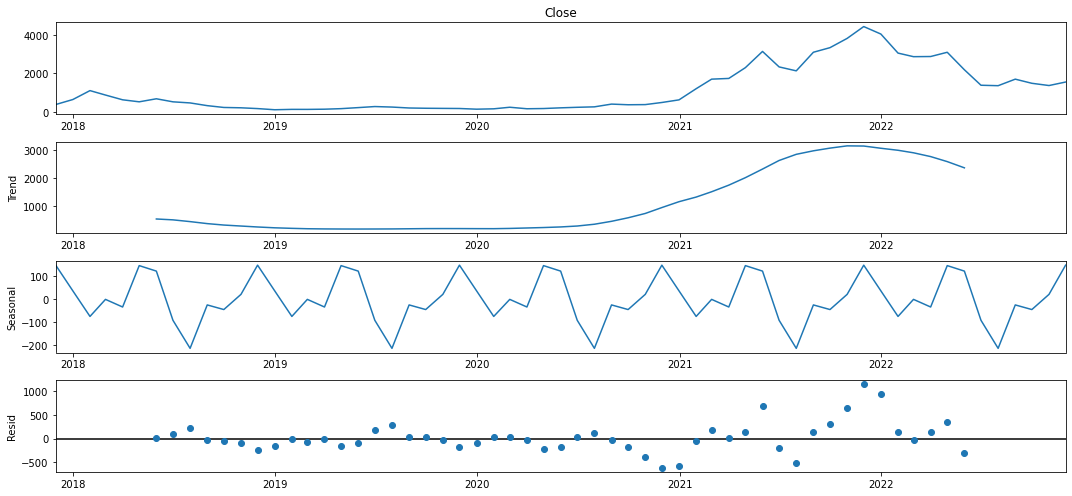

In [8]:
seasonal_decompose(btc_month.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
plt.show()

In [9]:
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])


Dickey–Fuller test: p=0.693592


In [10]:
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.255092


In [11]:
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.074047


Dickey–Fuller test: p=nan


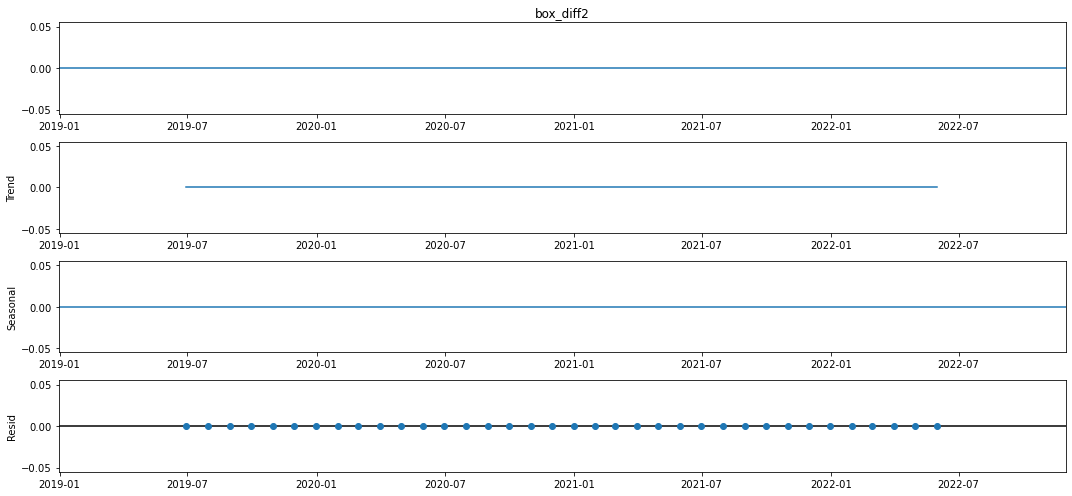

In [12]:
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12
seasonal_decompose(btc_month.box_diff2[13:]).plot() 
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])
plt.show()

In [13]:
btc_month.Close

Date
2017-11-30     379.732093
2017-12-31     640.209291
2018-01-31    1103.646004
2018-02-28     873.116318
2018-03-31     625.761325
                 ...     
2022-07-31    1359.407778
2022-08-31    1699.230370
2022-09-30    1484.229456
2022-10-31    1367.615620
2022-11-30    1549.708191
Freq: M, Name: Close, Length: 61, dtype: float64

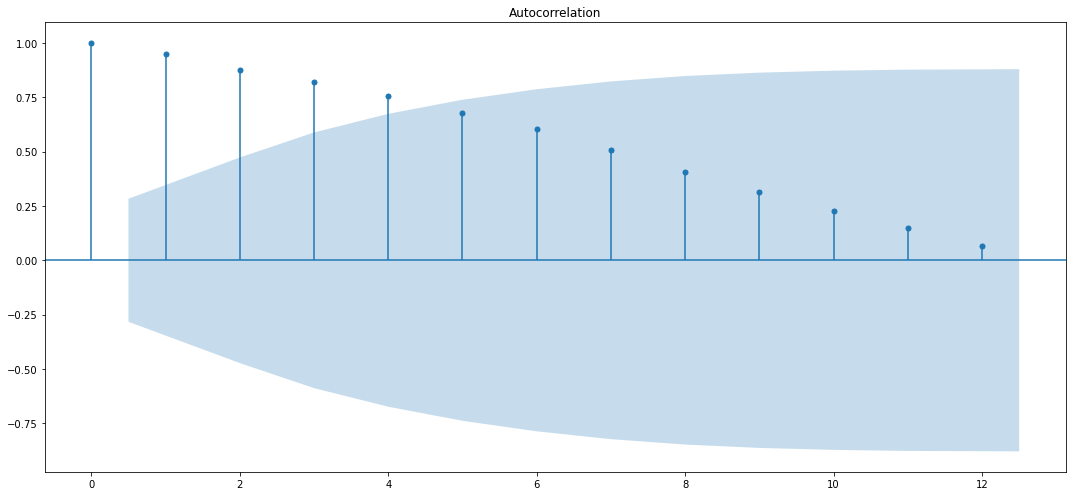

In [14]:
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()
plt.show()

LinAlgError: Singular matrix

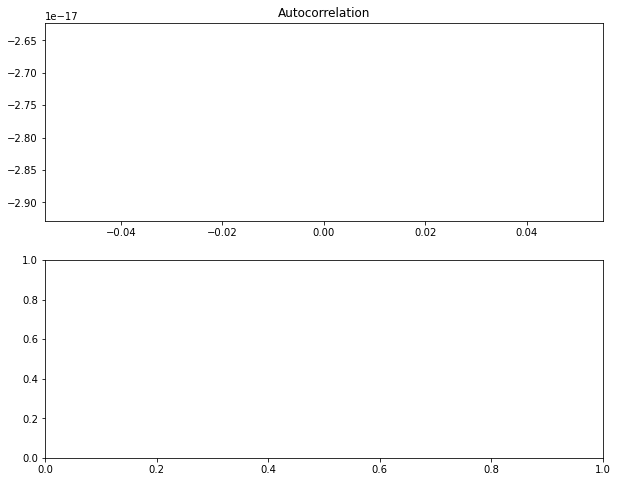

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax[0])
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax[1])
plt.tight_layout()
plt.show()

In [19]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    
    results.append([param, model.aic])



In [20]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())


  parameters        aic
1     (0, 1) -97.235794
3     (1, 0) -95.841541
4     (1, 1) -95.619938
2     (0, 2) -95.587482
6     (2, 0) -94.428791


In [21]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   61
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  50.618
Date:                Wed, 22 Mar 2023   AIC                            -97.236
Time:                        17:23:27   BIC                            -93.047
Sample:                    11-30-2017   HQIC                           -95.597
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3668      0.122      3.000      0.003       0.127       0.606
sigma2         0.0108      0.002      4.898      0.000       0.006       0.015
Ljung-Box (L1) (Q):                   0.12   Jarque-

In [22]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


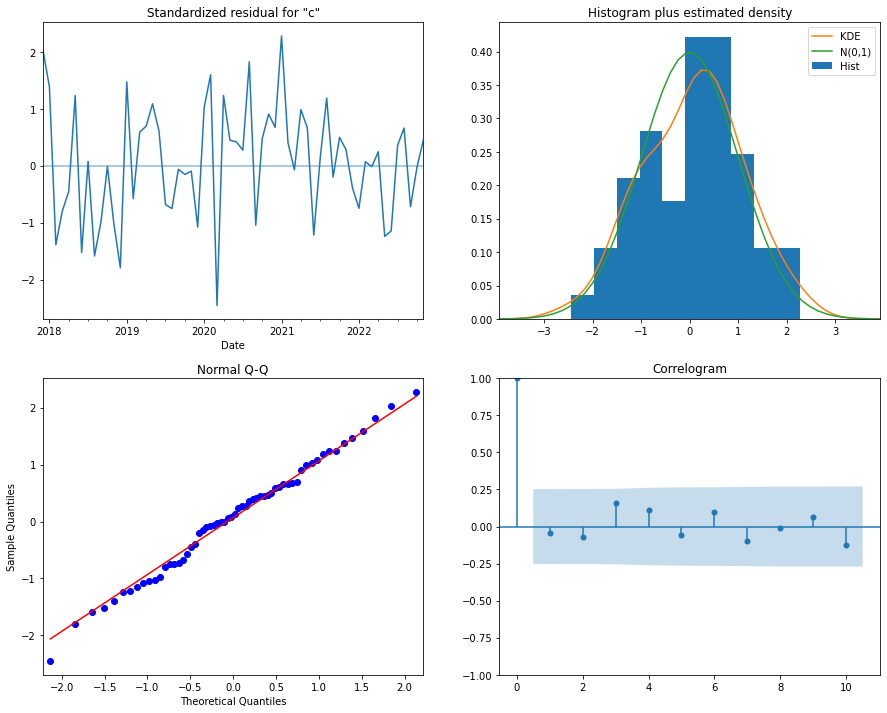

In [23]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [25]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [26]:
btc_month

,Open,High,Low,Close,Adj Close,Volume,close_box,box_diff_seasonal_12,box_diff_seasonal_3,box_diff2
Date,,,,,,,,,,
2017-11-30,373.696317,393.111908,363.283634,379.732093,379.732093,1.225341e+09,4.075557,NaN,NaN,NaN
2017-12-31,630.583997,667.252580,596.163133,640.209291,640.209291,2.576202e+09,4.300484,NaN,NaN,NaN
2018-01-31,1093.099893,1163.799714,1024.934606,1103.646004,1103.646004,5.277749e+09,4.518597,NaN,NaN,NaN
2018-02-28,882.527006,917.850394,825.723679,873.116318,873.116318,2.978337e+09,4.426729,NaN,0.351172,NaN
2018-03-31,640.787129,653.875259,606.506935,625.761325,625.761325,1.732780e+09,4.290985,NaN,-0.009499,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-07-31,1339.623811,1397.632990,1299.108965,1359.407778,1359.407778,1.724057e+10,4.597897,-0.163588,-0.292195,0.0
2022-08-31,1703.347814,1753.752186,1653.171245,1699.230370,1699.230370,1.787622e+10,4.680335,-0.209908,-0.090325,0.0
2022-09-30,1491.504883,1528.951184,1443.930957,1484.229456,1484.229456,1.655508e+10,4.630652,-0.284353,0.026370,0.0


In [27]:
btc_month.close_box

Date
2017-11-30    4.075557
2017-12-31    4.300484
2018-01-31    4.518597
2018-02-28    4.426729
2018-03-31    4.290985
                ...   
2022-07-31    4.597897
2022-08-31    4.680335
2022-09-30    4.630652
2022-10-31    4.600154
2022-11-30    4.646606
Freq: M, Name: close_box, Length: 61, dtype: float64

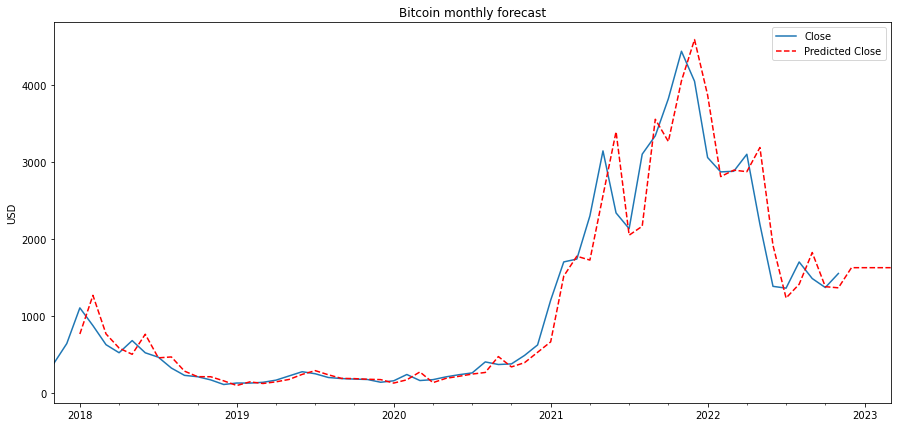

In [28]:
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2022, 12, 31), datetime(2023, 1, 31), datetime(2023, 2, 28), datetime(2023, 3, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])
#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2023, 3, 31)), lmbda)
plt.figure(figsize=(15,7))
btc_month_pred.Close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [29]:
btc_month_pred.Close.tail()

2022-11-30    1549.708191
2022-12-31            NaN
2023-01-31            NaN
2023-02-28            NaN
2023-03-31            NaN
Name: Close, dtype: float64

In [30]:
y_forecasted = btc_month_pred.forecast
y_truth = btc_month_pred['2018-1-31':'2022-11-30'].Close
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 332.17


In [1]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

Importing plotly failed. Interactive plots will not work.


In [32]:
pip install prophet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.24.2 which is incompatible.


  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732018 sha256=4511b4cf8afa7692e4b95f89d05e4c3ba2f3880075795e91376f78b2c139b978
  Stored in directory: c:\users\madulatha\appdata\local\pip\cache\wheels\04\1f\e5\8dd0c661cd8d252817655dc14a84f7ae045d6616594145aa81
Successfully built pymeeus
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


In [33]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [1]:
data= pd.read_csv("ETH-USD.csv", parse_dates=['Date'],date_parser=dateparse)
data()

NameError: name 'pd' is not defined

In [2]:
plt.figure(figsize=(5,5))
corr=data[data.columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data[data.columns[1:]].corr(), mask=mask, cmap='coolwarm', vmax=.3, center=0
 square=True, linewidths=.5,annot=True)
plt.show()


SyntaxError: invalid syntax (Temp/ipykernel_25320/1520278211.py, line 5)

In [3]:
prophet_df=data[['Date','Close']]
prophet_df.rename(columns={'Date':'ds','Close':'y'},inplace=True)

NameError: name 'data' is not defined

In [4]:
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

NameError: name 'Prophet' is not defined

In [5]:
future= prophet_basic.make_future_dataframe(periods=149)
future.tail(2)


NameError: name 'prophet_basic' is not defined

In [6]:
forecast=prophet_basic.predict(future)
fig1 =prophet_basic.plot(forecast)


NameError: name 'prophet_basic' is not defined

In [2]:
pip onstall prophet

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "onstall" - maybe you meant "install"



In [2]:
!pip install prophet
